# data

Load OHLC data from cryptocurrency exchange Poloniex

In [1]:
from vectorbt import data, graphics
from datetime import datetime
from importlib import reload
import pytz
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

In [2]:
ohlc_df = data.load_cryptopair('USDT_BTC', data.ago_dt(days=30), data.now_dt())
ohlc_df.head()

passed. 1.72s


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-10-20 16:15:00,5959.000000,5980.0,5948.9,5980.000000,24.459105,145857.669352,5963.328249
2017-10-20 16:20:00,5944.000000,5962.0,5941.0,5959.000000,28.747131,171049.479689,5950.140935
2017-10-20 16:25:00,5941.075000,5950.0,5935.0,5944.000000,14.004506,83261.078681,5945.306214
2017-10-20 16:30:00,5962.246757,5975.0,5940.0,5941.075000,47.656175,283991.959860,5959.184931
2017-10-20 16:35:00,5974.000000,5977.0,5962.0,5962.246757,36.112559,215730.799908,5973.844100


In [3]:
rate_sr = ohlc_df['open']

       count         mean         std      min     25%     50%     75%     max
open  8640.0  6607.868973  705.439095  5302.64  5950.0  6540.0  7220.0  8010.0


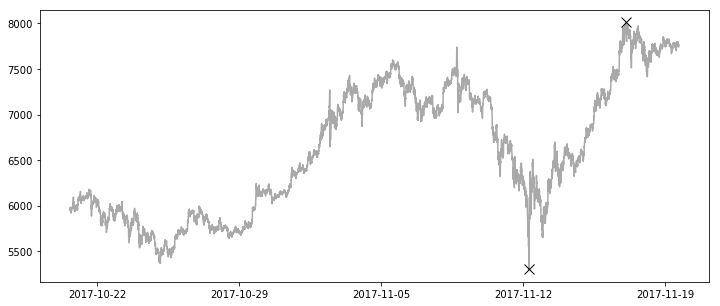

In [4]:
graphics.plot_line(rate_sr)

## indicators

Calculate simple moving averages

In [5]:
from vectorbt import indicators

In [6]:
fast_ma_sr = indicators.EMA(rate_sr, 50)
slow_ma_sr = indicators.EMA(rate_sr, 100)
print(fast_ma_sr.head())
print(slow_ma_sr.head())

date
2017-10-20 16:15:00    5980.000000
2017-10-20 16:20:00    5979.176471
2017-10-20 16:25:00    5977.797001
2017-10-20 16:30:00    5976.356923
2017-10-20 16:35:00    5975.803583
Name: open, dtype: float64
date
2017-10-20 16:15:00    5980.000000
2017-10-20 16:20:00    5979.584158
2017-10-20 16:25:00    5978.879522
2017-10-20 16:30:00    5978.130917
2017-10-20 16:35:00    5977.816379
Name: open, dtype: float64


# signals

Generate signals for the SMA crossover strategy

In [7]:
from vectorbt import signals
import numpy as np

Go long whenever fast SMA is over slow SMA by threshold (in % of current rate), while go short when opposite occurs

In [8]:
ma_entry_vector = signals.dmac_entry_vector(rate_sr, fast_ma_sr, slow_ma_sr, th=(0.01, 0.01))
ma_exit_vector = signals.dmac_exit_vector(rate_sr, fast_ma_sr, slow_ma_sr, th=(0.01, 0.01))

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to speed up vector operations and to allow application of additional filters on them. Each vector is reduced (and sparse) and contains only signals that are first in their sequences. This way, we get neither outdated signals, nor typical issues like entry immediatelly after exit or vice versa. To apply a filter, create your own (not sparse) bit-vector and multiply with signals.

# positions

In [9]:
from vectorbt import positions

Generete positions out of both vectors (merge and reduce)

In [10]:
pos_sr = positions.from_vectors(rate_sr, ma_entry_vector, ma_exit_vector)
pos_sr.head()

date
2017-10-29 20:20:00    1
2017-11-06 19:30:00   -1
2017-11-12 11:25:00    1
2017-11-12 22:05:00   -1
2017-11-13 06:45:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

      count        mean         std         min         25%         50%  \
open    6.0  261.402839  811.980666 -680.043411 -357.656579  240.156705   

             75%          max  
open  688.484931  1487.147032  


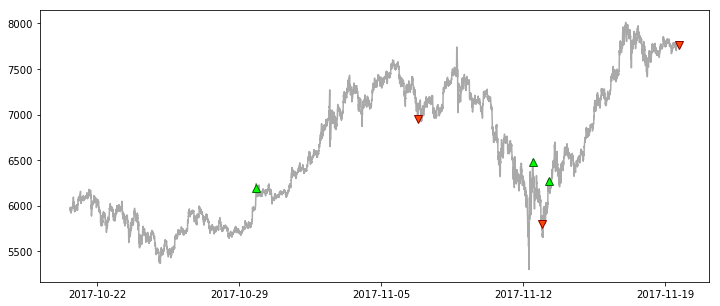

In [11]:
positions.plot(rate_sr, pos_sr)

# returns

In [12]:
from vectorbt import returns

Generate % returns out of positions. Takes into account fees.

In [13]:
posret_sr = returns.from_positions(rate_sr, pos_sr, 0.0015)
posret_sr.head()

date
2017-10-29 20:20:00   -0.001500
2017-11-06 19:30:00    0.120653
2017-11-12 11:25:00   -0.001500
2017-11-12 22:05:00   -0.106352
2017-11-13 06:45:00   -0.001500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [14]:
returns.on_hold(rate_sr, 0.0015)

date
2017-10-20 16:15:00   -0.001500
2017-11-19 16:10:00    0.296283
dtype: float64

   count      mean       std       min     25%     50%       75%       max
0    6.0  0.040816  0.119288 -0.106352 -0.0015 -0.0015  0.090115  0.235092


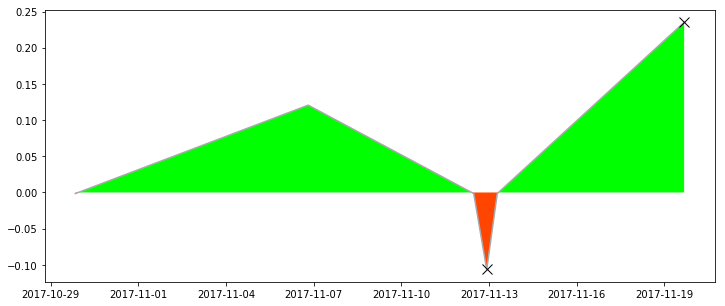

In [15]:
returns.plot(posret_sr)

# equity

In [16]:
from vectorbt import equity

Generate equity in base and quote currency from position returns

In [17]:
equity_df = equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-20 16:15:00,NaN,NaN
2017-10-20 16:20:00,NaN,NaN
2017-10-20 16:25:00,NaN,NaN
2017-10-20 16:30:00,NaN,NaN
2017-10-20 16:35:00,NaN,NaN


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count       mean         std         min         25%       50%       75%  \
0  5999.0 -25.751827  238.196356 -807.967544 -123.058388 -11.26818 -9.637154   

           max  
0  1629.392456  


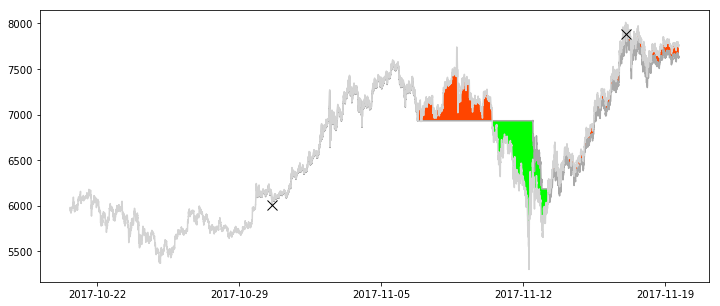

quote
    count      mean     std       min      25%     50%     75%       max
0  5999.0 -0.002144  0.0371 -0.104389 -0.01594 -0.0015 -0.0015  0.307279


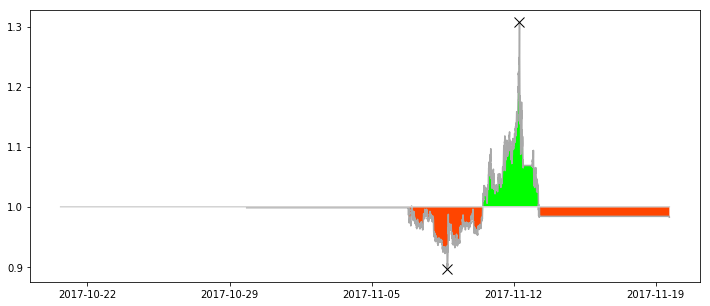

In [18]:
equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [19]:
eqd_sr = equity.diff_on_positions(posret_sr)
eqd_sr.head()

date
2017-10-29 20:20:00   -0.001500
2017-11-06 19:30:00    0.120472
2017-11-12 11:25:00   -0.001678
2017-11-12 22:05:00   -0.118827
2017-11-13 06:45:00   -0.001498
dtype: float64

# kpi

Every indicator uses equity diffs as input

In [20]:
from vectorbt import kpi
import json

In [21]:
kpi.print_summary(eqd_sr)

{
  "backtest": {
    "from": "2017-10-29 20:20:00",
    "to": "2017-11-19 16:10:00",
    "days": 20,
    "trades": 6
  },
  "performance": {
    "profit": 0.2313489239978952,
    "averages": {
      "trade": 0.07867502755408222,
      "gain": 0.17742590529503222,
      "loss": 0.11882672792781779
    },
    "winrate": 0.6666666666666666,
    "payoff": 1.493148119022607,
    "PF": 2.986296238045214,
    "RF": 1.986296238045214
  },
  "risk/return profile": {
    "sharpe": 5.427101341500011,
    "sortino": 10.690260626026111,
    "maxdd": 0.11882672792781779
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 5 levels:**

| Level | Operation | Result | Use cases |
|-|-|-|-|
| L1 | Calculate positions | `posmap` (dict) | Transformed into returns, equity or equity diffs |
| L2 | Calculate equity diffs | `eqdmap` (dict) | Used in calculation of indicators |
| L3 | Apply KPIs | `kpimap_sr` (series) | Used in comparing strategies, building a score or a matrix |
| L4 | Bind KPIs into a score | `scoremap_sr` (series) | Takes into account and examines multiple KPIs |
| L5 | Convert into a matrix | `matrix_df` (dataframe) | Constructs a heatmap |

At the end we will be able to compare performance of different trading strategies.

## L1
## posmap

Position series keyed by parameter combinations

In [22]:
from vectorbt.optimizer.gridsearch import posmap

Generate combinations of fast and slow SMA (from 1 to 100) and their resulting positions

In [23]:
sma_posmap = posmap.ma(rate_sr, 1, 100, 1, (0.01, 0.01), indicators.SMA)

ma-posmap
setup: ma_func = SMA, th = (0.01, 0.01)
grid: 1.000000 -> 100.000000 = 5050
calcs: 5050 (~14.95s)
passed. 8.68s


Generate random positions of magnitude similar to the map above (to be comparable)

In [24]:
import math
n = math.ceil(np.median([len(pos_sr.index) for pos_sr in sma_posmap.values() if len(pos_sr.index) > 0]))
N = len(sma_posmap)
random_posmap = posmap.random(rate_sr, n, N)

random-posmap
setup: positions = ~24, N = 5050
calcs: 5050 (~24.55s)
passed. 6.47s


## L2
## eqdmap

Translate each position series in the `posmap` into equity diffs

In [25]:
from vectorbt.optimizer.gridsearch import eqdmap

In [26]:
sma_eqdmap = eqdmap.from_posmap(rate_sr, sma_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 (~33.24s)
passed. 14.16s


In [27]:
random_eqdmap = eqdmap.from_posmap(rate_sr, random_posmap, 0.0015)

eqdmap
setup: fees = 0.001500
calcs: 5050 (~26.56s)
passed. 14.62s


## L3 
## kpimap

Apply indicator (KPI) on each equity diffs series in the `eqdmap`

In [28]:
from vectorbt.optimizer.gridsearch import kpimap

In [29]:
sma_kpimap1_sr = kpimap.from_eqdmap(sma_eqdmap, kpi.expectancy)

expectancy-kpimap
calcs: 5050 (~1.63s)
min (2, 3): -0.12458152267
max (9, 11): 0.324601580999
passed. 0.50s


In [30]:
sma_kpimap2_sr = kpimap.from_eqdmap(sma_eqdmap, kpi.sharpe)

sharpe-kpimap
calcs: 5050 (~12.95s)
min (38, 49): -12.7261002547
max (13, 19): 14.2889383193
passed. 6.07s


In [31]:
random_kpimap_sr = kpimap.from_eqdmap(random_eqdmap, kpi.expectancy)

expectancy-kpimap
calcs: 5050 (~1.93s)
min 4964: -0.0320683721786
max 3141: 0.0690621530576
passed. 0.60s


Compare KPI maps on basic properties and quantiles distribution

    count      mean       std       min       25%       50%       75%  \
0  5050.0  0.009502  0.011855 -0.032068  0.001084  0.008683  0.016556   
1  4543.0  0.055442  0.089865 -0.124582  0.000141  0.006068  0.071445   

        max  
0  0.069062  
1  0.324602  


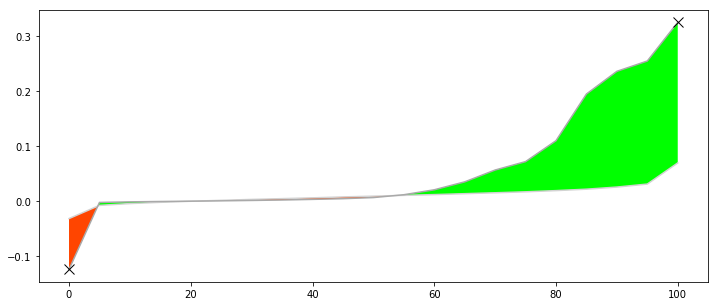

In [32]:
kpimap.compare(random_kpimap_sr, sma_kpimap1_sr)

## L4
## scoremap

Take into account multiple weighted indicators and generate a score from 1 to 100

In [33]:
from vectorbt.optimizer.gridsearch import scoremap

In [34]:
sma_scoremap_sr = scoremap.from_kpimaps([sma_kpimap1_sr, sma_kpimap2_sr], [2/3, 1/3], [False, False])

1-100-scoremap
min (1, 1): 1.0
max (9, 11): 96.1310944763
passed. 0.01s


## L5 
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [35]:
from vectorbt.optimizer.gridsearch import matrix
from matplotlib import pyplot as plt
import pandas as pd

In [36]:
sma_matrix_df = matrix.from_map(sma_kpimap1_sr, symmetric=True).fillna(0)

100-100-matrix
passed. 1.41s


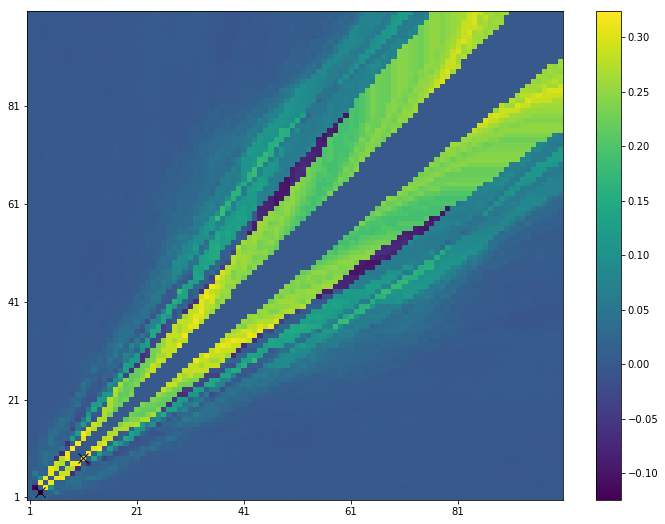

In [37]:
cmap = plt.cm.viridis
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
matrix.plot(sma_matrix_df, cmap, norm)

Compare KPI distribution to that of random map

    count      mean       std       min       25%       50%       75%  \
0  4543.0  0.055442  0.089865 -0.124582  0.000141  0.006068  0.071445   

        max  
0  0.324602  


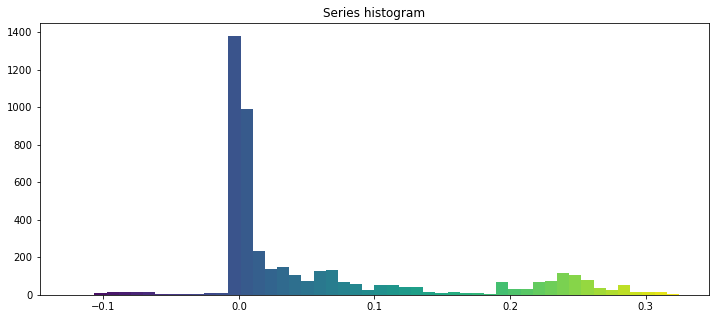

In [38]:
matplotlib.rcParams['figure.figsize'] = (12, 5)
graphics.plot_hist(sma_kpimap1_sr.dropna(), cmap, norm)

    count      mean       std       min       25%       50%       75%  \
0  5052.0  0.009538  0.012794 -0.124582  0.001081  0.008683  0.016561   

        max  
0  0.324602  


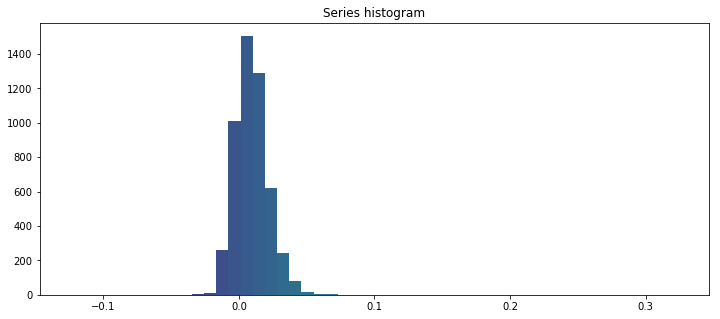

In [39]:
# Adjust bounds
to_plot = random_kpimap_sr.append(pd.Series(sma_kpimap1_sr.min())).append(pd.Series(sma_kpimap1_sr.max()))
graphics.plot_hist(to_plot, cmap, norm)